In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import itertools
import re
import time

from collections import Counter

sns.set(style="white", color_codes=True,font_scale=1)
%matplotlib inline

For both leagues, we extract the rankings for each season, we drop the features we don't use, and we plot three different things.

- the distribution of team rankings at the end of each season
- the distribution of team points at the end of each season
- the comparison between rankings in Playoff and regular season.

# LNA

In [2]:
# import data for seasonal rankings
rankings_path = 'Data/Team/Rankings/Regular/LNA/*'
df_rankings_lna = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[31:35]
    df_rankings_lna.append(frame)
df_rankings_lna = pd.concat(df_rankings_lna)
df_rankings_lna.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_rankings_lna.head(15)

,R,Team,GP,W,OTW,SOW,SOL,OTL,L,GF,GA,GDF,PTS,Season
0,1,SC Bern,50,30,4,0,2,3,11,187,136,51,103,0809
1,2,ZSC Lions,50,26,3,5,0,3,13,176,149,27,97,0809
2,3,Kloten Flyers,50,27,3,3,2,1,14,174,130,44,96,0809
3,4,HC Davos,50,25,3,3,3,2,14,184,135,49,92,0809
4,5,HC Lugano,50,19,4,4,5,2,16,175,156,19,80,0809
5,6,Genève-Servette HC,50,22,5,0,2,0,21,157,140,17,78,0809
6,7,Fribourg-Gottéron,50,19,3,4,1,3,20,154,143,11,75,0809
7,8,EV Zug,50,20,1,2,2,3,22,171,166,5,71,0809
8,9,SCL Tigers,50,19,2,3,1,1,24,170,180,-10,69,0809
9,10,SC Rapperswil-Jona Lakers,50,14,0,1,2,3,30,143,208,-65,49,0809


In [3]:
# helper to sort plots by median rank/pts
temp_lna = df_rankings_lna.groupby('Team').agg({'R': 'median', 'PTS': 'median'})
t1_lna = temp_lna.sort_values(by='R',inplace=False)
t2_lna = temp_lna.sort_values(by='PTS',ascending=False)

In [4]:
df_rankings_lna_grouped = df_rankings_lna.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first', 'PTS': 'first'})
df_features_lna = df_rankings_lna.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first'})
df_rankings_lna.drop(['GP','W','OTW','SOW','SOL','OTL','L','GF','GA','GDF','PTS','Season'],axis=1,inplace=True)

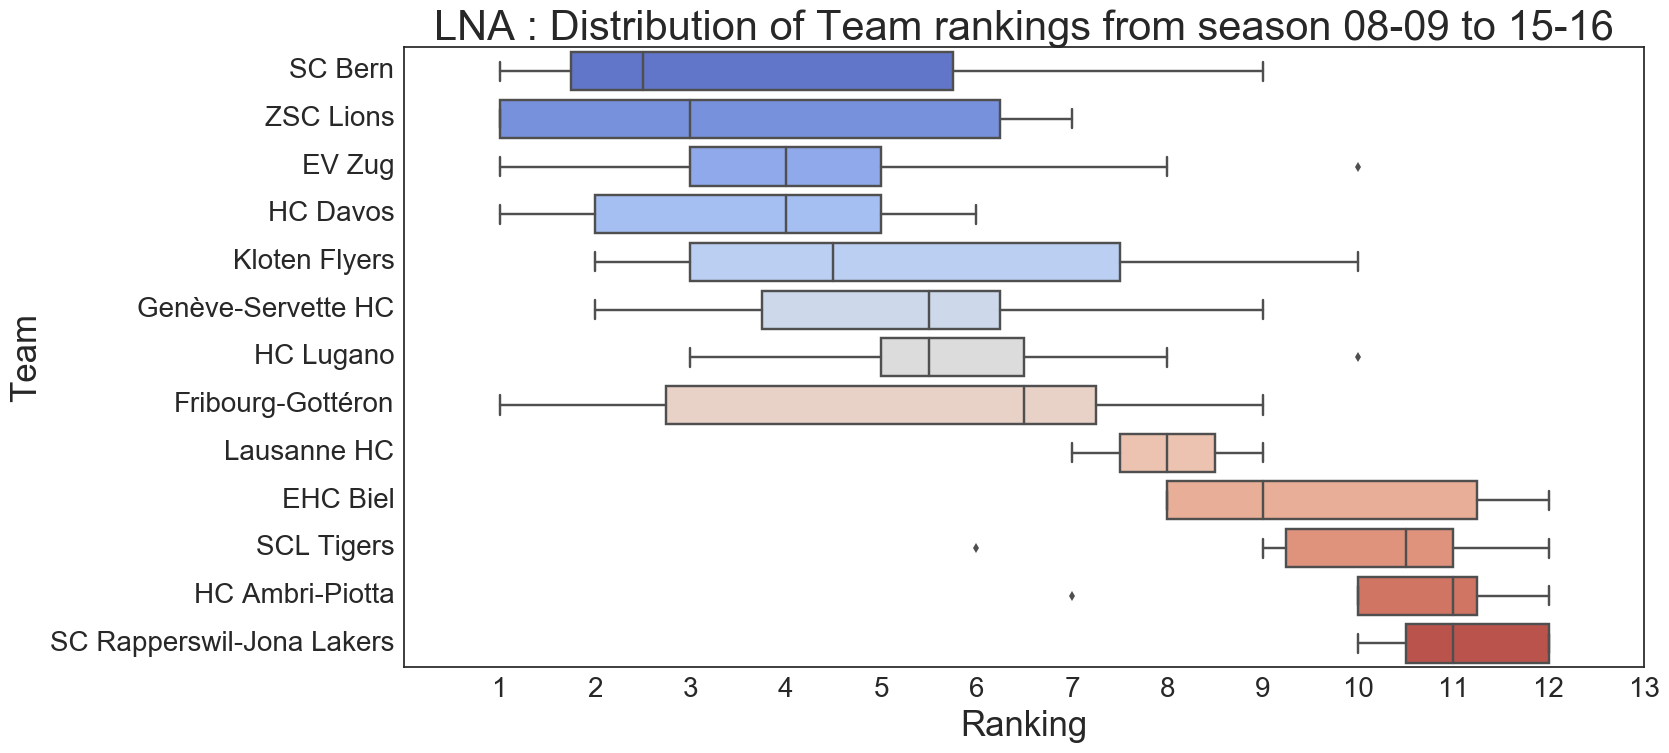

In [5]:
sns.set(style="white", color_codes=True,font_scale=1)
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='R', y='Team',data=df_rankings_lna_grouped.reset_index(), orient="h", palette='coolwarm', order=t1_lna.index)
ax.set_xlabel('Ranking', fontsize=25)
ax.set_xticks(np.arange(1,14))
ax.set_title('LNA : Distribution of Team rankings from season 08-09 to 15-16', fontsize=30);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Team',fontsize=25)

# plt.savefig('Plots/lna_rank_distrib.png')

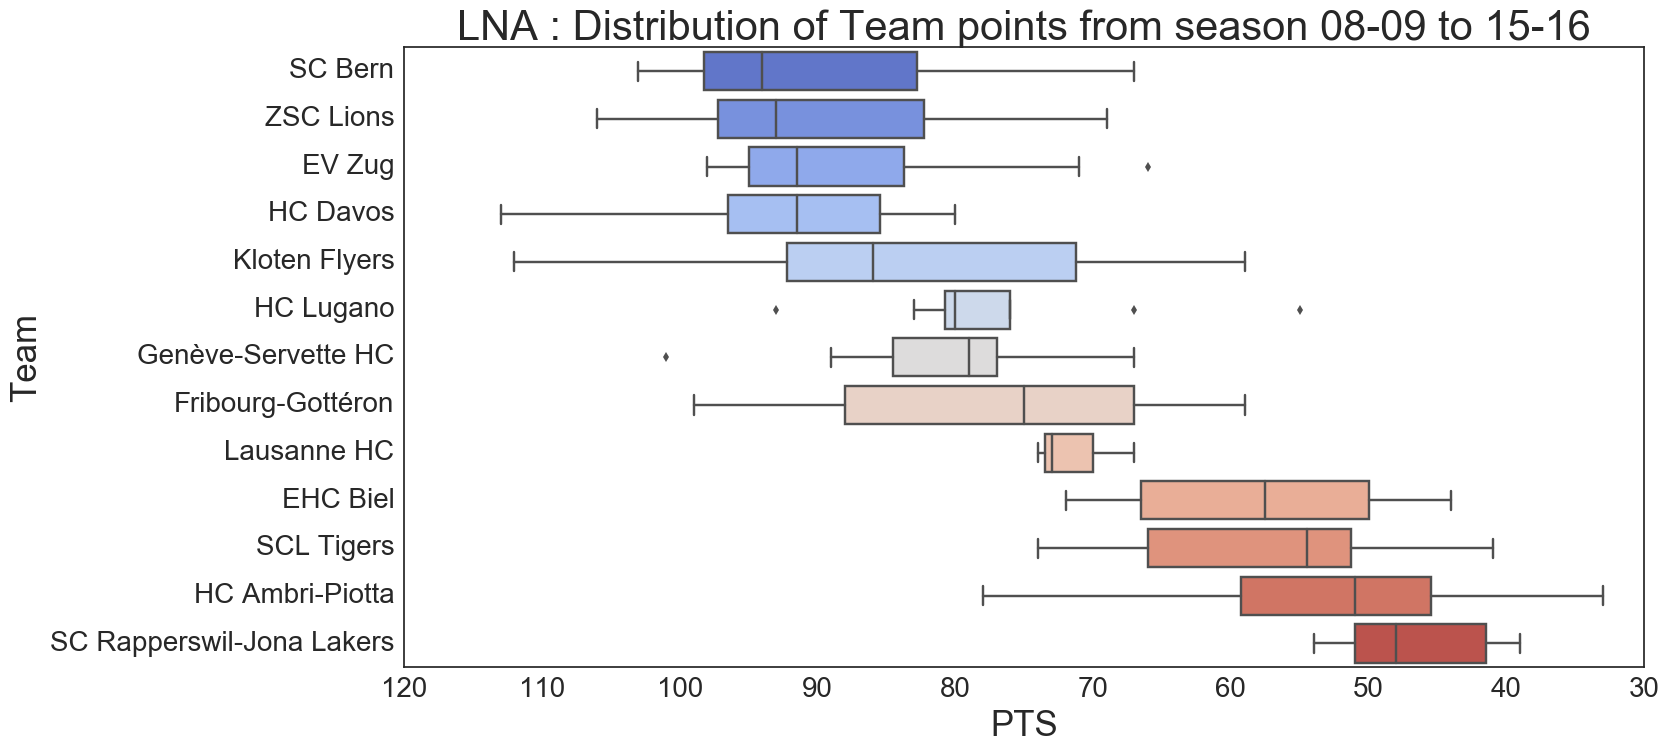

In [6]:
sns.set(style="white", color_codes=True,font_scale=1)
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings_lna_grouped.reset_index(), orient="h", palette='coolwarm', order=t2_lna.index)
ax.set_xlabel('PTS', fontsize=25)
ax.invert_xaxis()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Team',fontsize=25)
ax.set_title('LNA : Distribution of Team points from season 08-09 to 15-16', fontsize=30);

# plt.savefig('Plots/lna_points_distrib.png')

In [7]:
playoff_ranks_lna = [5,5,2,1,5,5,3,3,
                1,2,3,5,3,5,5,5,
                1,2,3,3,5,5,5,5,
                3,5,3,5,2,5,1,5,
                2,1,3,3,5,5,5,5,
                1,3,2,3,5,5,5,5,
                2,3,5,5,1,3,5,5,
                5,3,3,5,2,5,5,1]
df_rankings_lna = df_rankings_lna[df_rankings_lna['R'] <= 8]

In [8]:
df_rankings_lna['playoff'] = playoff_ranks_lna
df_rankings_lna.rename(index=str, columns={'playoff' : 'rank_PO', 'R' : 'rank_RE'},inplace=True)
df_rankings_lna['number'] = 100
df_rankings_lna_agg = df_rankings_lna.groupby(by=['rank_RE', 'rank_PO']).agg({'number' : 'sum'}).reset_index()

In [9]:
df_rankings_lna_agg['total'] = df_rankings_lna_agg.apply(lambda x: x.loc['rank_RE']*x.loc['number'], axis=1)
df_rankings_lna_mean = df_rankings_lna_agg.groupby(['rank_PO']).agg({'total' : 'sum', 'number' : 'sum'})
df_rankings_lna_mean['mean'] = df_rankings_lna_mean['total']/df_rankings_lna_mean['number']
df_rankings_lna_mean

,total,number,mean
rank_PO,,,
1,2900,800,3.62500
2,2200,800,2.75000
3,6000,1600,3.75000
5,17700,3200,5.53125


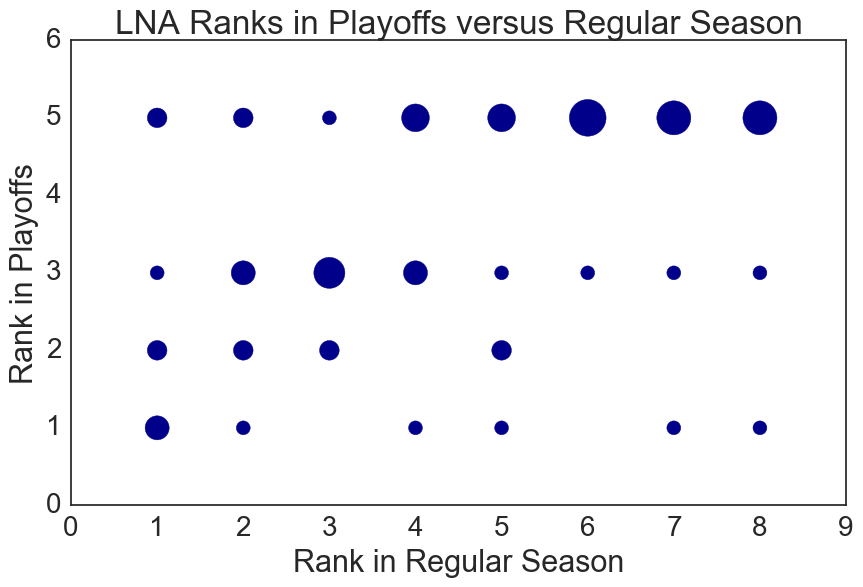

In [10]:
sns.set(style='white',color_codes=True,font_scale=2)
plt.figure(figsize=(10,6))
plt.scatter(x=df_rankings_lna_agg['rank_RE'],y=df_rankings_lna_agg['rank_PO'],
            s=df_rankings_lna_agg['number'], color='darkblue', label='data')
plt.xlabel('Rank in Regular Season')
plt.ylabel('Rank in Playoffs')
plt.title('LNA Ranks in Playoffs versus Regular Season')

# plt.savefig('Plots/lna_PO_vs_RE.png')

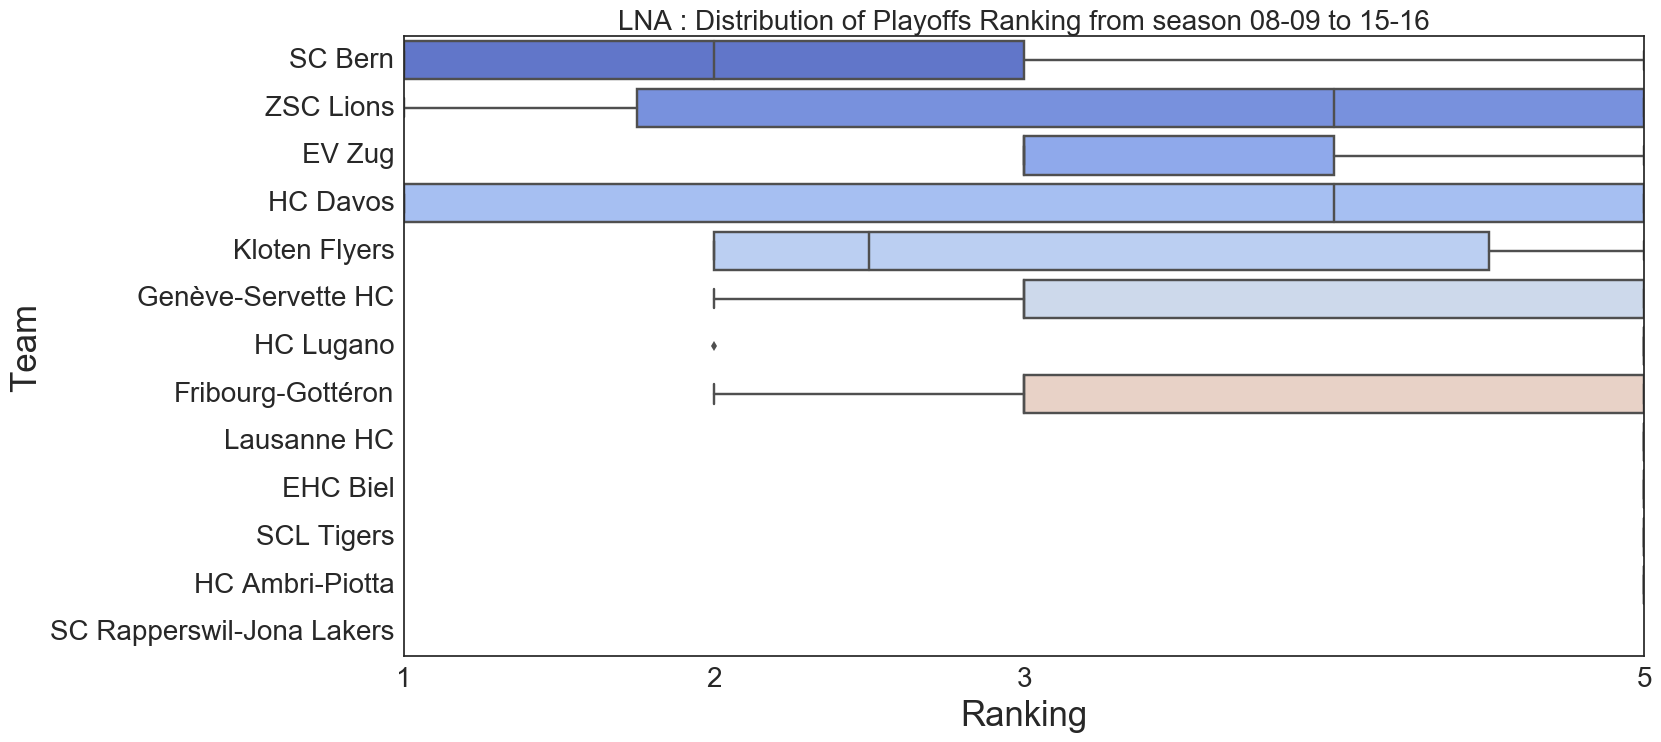

In [11]:
sns.set(style="white", color_codes=True,font_scale=1)
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='rank_PO', y='Team',data=df_rankings_lna, orient="h", palette='coolwarm', order=t1_lna.index)
ax.set_xlabel('Ranking', fontsize=25)
ax.set_xticks([1,2,3,5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Team',fontsize=25)
ax.set_title('LNA : Distribution of Playoffs Ranking from season 08-09 to 15-16', fontsize=20);

# plt.savefig('Plots/lna_playoff_distrib.png')

# LNB

In [12]:
# import data for seasonal rankings
rankings_path = 'Data/Team/Rankings/Regular/LNB/*'
df_rankings_lnb = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[31:35]
    df_rankings_lnb.append(frame)
df_rankings_lnb = pd.concat(df_rankings_lnb)
df_rankings_lnb.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_rankings_lnb.head(15)

,R,Team,GP,W,OTW,SOW,SOL,OTL,L,GF,GA,GDF,PTS,Season
0,1,EHC Visp,45,27,3,3,1,1,10,224,140,84,95,0910
1,2,EHC Olten,45,30,0,1,2,0,12,187,129,58,94,0910
2,3,Lausanne HC,45,28,1,1,2,1,12,166,121,45,91,0910
3,4,HC Sierre,45,21,2,3,4,3,12,161,132,29,80,0910
4,5,HC Ajoie,45,21,3,2,1,1,17,157,149,8,75,0910
5,6,HC La Chaux-de-Fonds,45,20,2,0,4,0,19,177,166,11,68,0910
6,7,SC Langenthal,45,16,0,3,0,0,26,124,156,-32,54,0910
7,8,EHC Basel Sharks,45,12,0,1,2,2,28,111,180,-69,42,0910
8,9,Hockey Thurgau,45,12,0,1,1,3,28,131,189,-58,42,0910
9,10,GCK Lions,45,10,0,2,0,0,33,123,199,-76,34,0910


In [13]:
# helper to sort plots by median rank/pts
temp_lnb = df_rankings_lnb.groupby('Team').agg({'R': 'median', 'PTS': 'median'})
t1_lnb = temp_lnb.sort_values(by='R',inplace=False)
t2_lnb = temp_lnb.sort_values(by='PTS',ascending=False)

In [14]:
df_rankings_lnb_grouped = df_rankings_lnb.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first', 'PTS': 'first'})
df_features_lnb = df_rankings_lnb.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first'})
df_rankings_lnb.drop(['GP','W','OTW','SOW','SOL','OTL','L','GF','GA','GDF','PTS','Season'],axis=1,inplace=True)

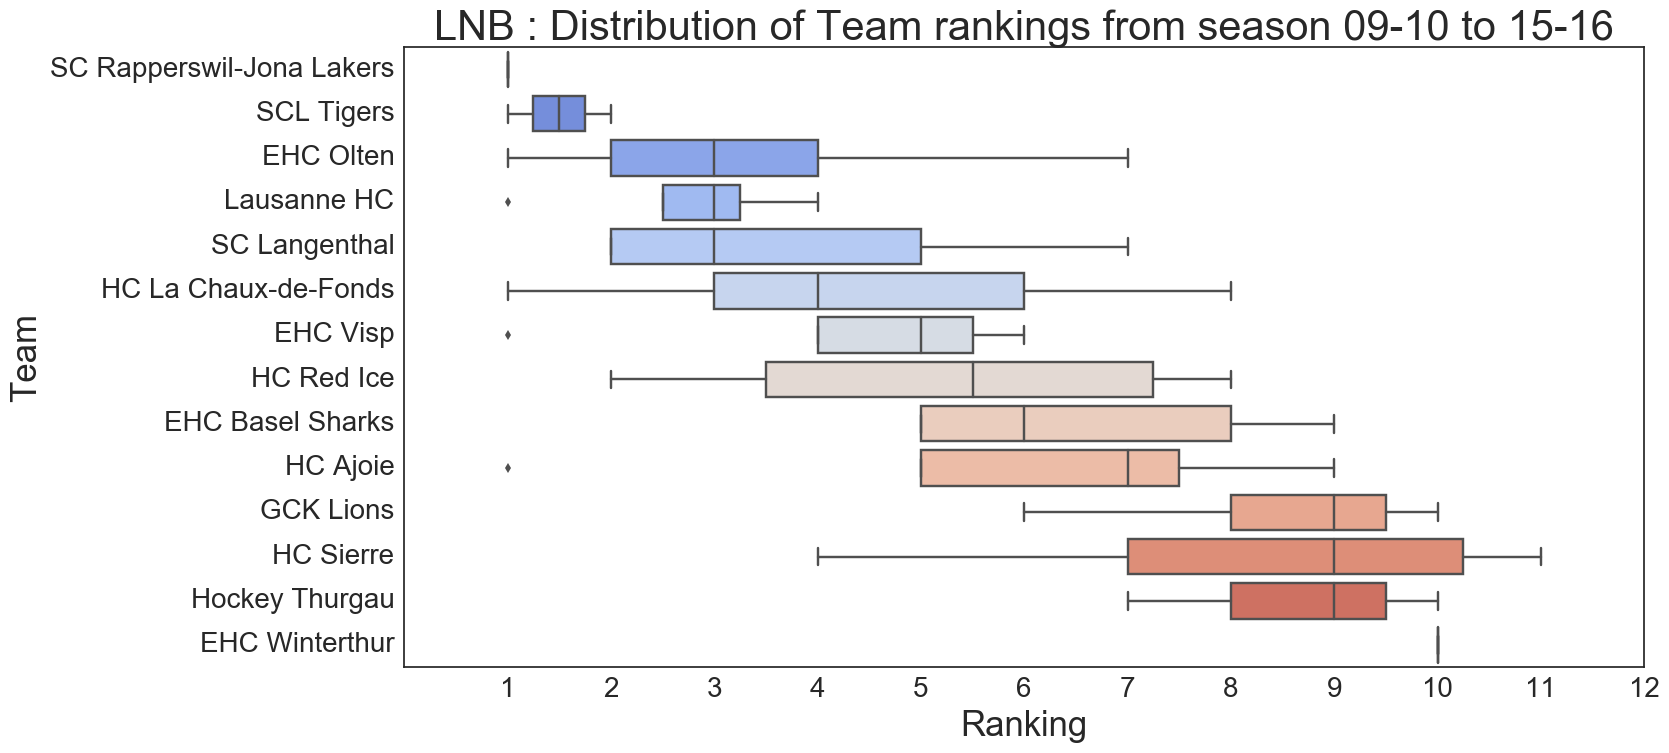

In [15]:
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='R', y='Team',data=df_rankings_lnb_grouped.reset_index(), orient="h", palette='coolwarm', order=t1_lnb.index)
ax.set_xlabel('Ranking', fontsize=25)
ax.set_xticks(np.arange(1,13))
ax.set_title('LNB : Distribution of Team rankings from season 09-10 to 15-16', fontsize=30);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Team',fontsize=25)
plt.savefig('Plots/lnb_rank_distrib.png')

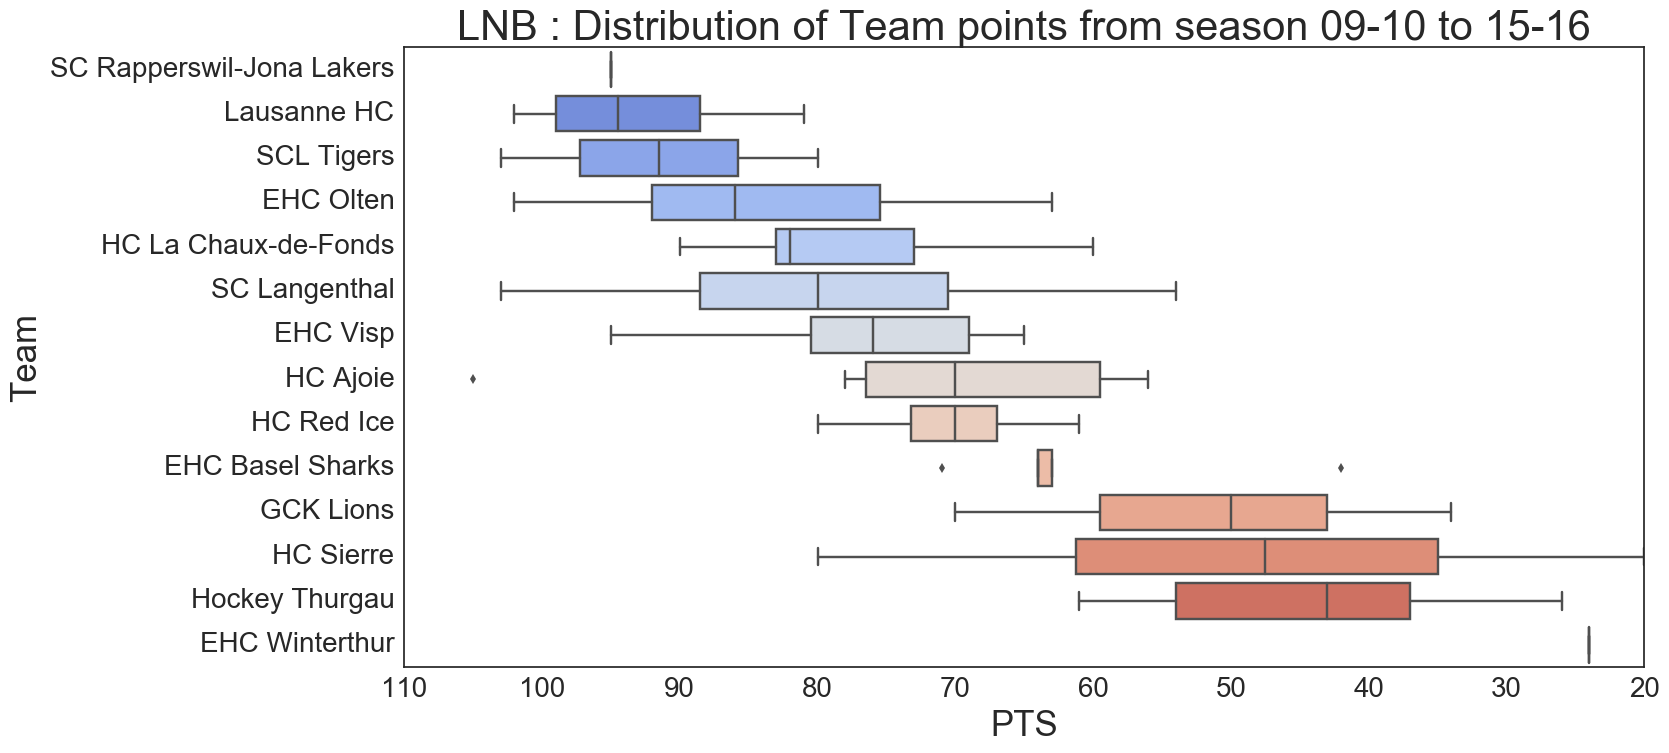

In [16]:
sns.set(style="white", color_codes=True,font_scale=1)
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings_lnb_grouped.reset_index(), orient="h", palette='coolwarm', order=t2_lnb.index)
ax.set_xlabel('PTS', fontsize=25)
ax.invert_xaxis()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Team',fontsize=25)
ax.set_title('LNB : Distribution of Team points from season 09-10 to 15-16', fontsize=30);

# plt.savefig('Plots/lna_points_distrib.png')

In [17]:
playoff_ranks_lnb = [2,3,1,3,5,5,5,5,
                    3,3,2,5,5,1,5,5,
                    2,1,3,3,5,5,5,5,
                    3,3,2,1,5,5,5,5,
                    5,2,3,5,1,5,5,3,
                    1,3,5,5,2,3,5,5,
                    2,5,3,5,5,5,3,5]
df_rankings_lnb = df_rankings_lnb[df_rankings_lnb['R'] <= 8]

In [18]:
df_rankings_lnb['playoff'] = playoff_ranks_lnb
df_rankings_lnb.rename(index=str, columns={'playoff' : 'rank_PO', 'R' : 'rank_RE'},inplace=True)
df_rankings_lnb['number'] = 100
df_rankings_lnb_agg = df_rankings_lnb.groupby(by=['rank_RE', 'rank_PO']).agg({'number' : 'sum'}).reset_index()

In [19]:
df_rankings_lnb_agg['total'] = df_rankings_lnb_agg.apply(lambda x: x.loc['rank_RE']*x.loc['number'], axis=1)
df_rankings_lnb_mean = df_rankings_lnb_agg.groupby(['rank_PO']).agg({'total' : 'sum', 'number' : 'sum'})
df_rankings_lnb_mean['mean'] = df_rankings_lnb_mean['total']/df_rankings_lnb_mean['number']
df_rankings_lnb_mean

,total,number,mean
rank_PO,,,
1,2100,600,3.500000
2,1600,700,2.285714
3,4800,1400,3.428571
5,16700,2900,5.758621


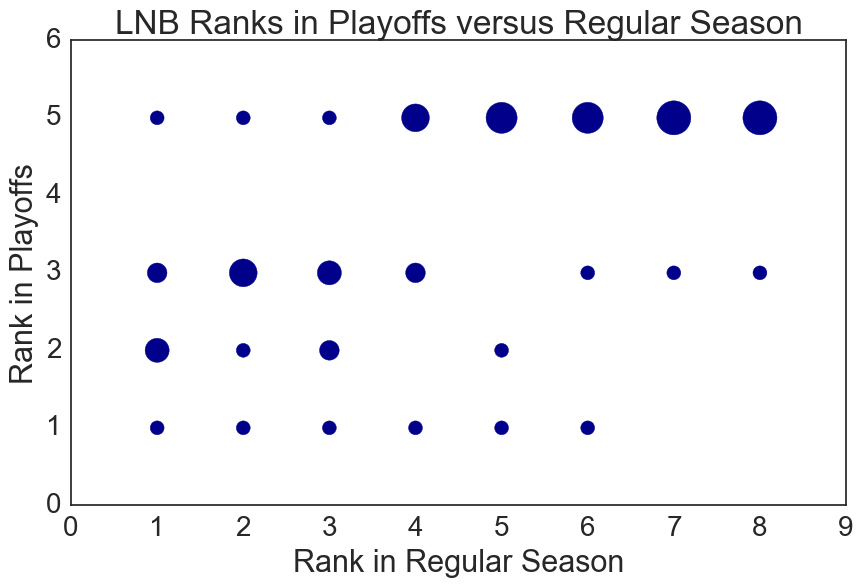

In [20]:
sns.set(style='white',color_codes=True,font_scale=2)
plt.figure(figsize=(10,6))
plt.scatter(x=df_rankings_lnb_agg['rank_RE'],y=df_rankings_lnb_agg['rank_PO'],
            s=df_rankings_lnb_agg['number'], color='darkblue', label='data')
plt.xlabel('Rank in Regular Season')
plt.ylabel('Rank in Playoffs')
plt.title('LNB Ranks in Playoffs versus Regular Season')

# plt.savefig('Plots/lnb_PO_vs_RE.png')

# Features

We load the features per team in a dataframe, for both LNA and LNB.

In [21]:
df_stats = pd.read_csv('Data/Team/LNA_LNB_features.csv')
df_stats.rename(index=str, columns={'Year' : 'Season'}, inplace=True)
df_stats.set_index(['Team','Season'], inplace=True)
df_stats.drop(['Number of year'],axis=1,inplace=True)
df_stats.head(10)

GF  PK SI PK SI/GP  PK GA PK GA/GP    PK%    PKT  \
Team             Season                                                      
EHC Basel Sharks 910     111    224     4.98     53     1.18  76.34  19961   
                 1011    138    211     4.69     38     0.84  81.99  19849   
                 1112    132    212     4.71     45      1.0  78.77  18770   
                 1213    138    232     4.64     46     0.92  80.17  21341   
                 1314    144    209     4.64     41     0.91  80.38  19490   
EHC Biel         809     126    306     6.12     55      1.1  82.03  27694   
                 910     134    266     5.32     45      0.9  83.08  24336   
                 1011    135    201     4.02     47     0.94  76.62  19409   
                 1112    114    200      4.0     35      0.7   82.5  19787   
                 1213    160    198     3.96     33     0.66  83.33  19053   

                         PK time/GP  SHG PK GF/GP     ...     5'  10' GM  MP  \
Team             Season                               ...                      
EHC Basel Sharks 910            443    2     0.04     ...      0   12  0   0   
                 1011           441    6     0.13     ...      3    2  2   2   
                 1112           417    9      0.2     ...      1    4  0   1   
                 1213           426    8     0.16     ...      2   10  1   1   
                 1314           433    8     0.18     ...      3   12  2   1   
EHC Biel         809            553    3     0.06     ...      2    8  4   0   
                 910            486    7     0.14     ...      2   12  1   1   
                 1011           388    3     0.06     ...      4    8  4   0   
                 1112           395    1     0.02     ...      6    2  5   1   
                 1213           381    7     0.14     ...      1    8  1   0   

                        PIM Total  PP OP PP OP/GP    PP%    PPT  PP time/GP  
Team             Season                                                      
EHC Basel Sharks 910          642    198     4.40  16.67  18182         404  
                 1011         597    197     4.38  16.75  18728         416  
                 1112         517    183     4.07  14.75  16934         376  
                 1213         662    189     3.78  18.52  18475         369  
                 1314         667    185     4.11  21.62  17106         380  
EHC Biel         809          812    261     5.22  11.11  25912         518  
                 910          776    259     5.18  16.99  23920         478  
                 1011         632    201     4.02   19.4  19384         387  
                 1112         602    198     3.96  15.15  19433         388  
                 1213         583    231     4.62  16.02  21809         436  

[10 rows x 34 columns]

## LNA

For the LNA, we drop the results of the 2008-2009 season, as we don't have enough features available for this season.

In [22]:
df_features_lna.reset_index(inplace=True)
df_features_lna[['Season']] = df_features_lna[['Season']].apply(pd.to_numeric)
df_features_lna = df_features_lna.drop(df_features_lna[df_features_lna.Season == 809].index)
df_features_lna.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_features_lna.set_index(['Team','Season'],inplace=True)
df_features_lna.head(5)

R
Team     Season    
EHC Biel 910      9
         1011     9
         1112     8
         1213     8
         1314    11

In [23]:
df_feat_viz_lna = df_features_lna.join(df_stats, how='inner')
df_feat_viz_lna['League'] = 'LNA'
df_feat_viz_lna.head(10)

R   GF  PK SI PK SI/GP  PK GA PK GA/GP    PK%    PKT  \
Team     Season                                                          
EHC Biel 910      9  134    266     5.32     45      0.9  83.08  24336   
         1011     9  135    201     4.02     47     0.94  76.62  19409   
         1112     8  114    200      4.0     35      0.7   82.5  19787   
         1213     8  160    198     3.96     33     0.66  83.33  19053   
         1314    11  115    197     3.94     34     0.68  82.74  17888   
         1415     8  142    167     3.34     37     0.74  77.84  15684   
         1516    12  128    197     3.94     53     1.06   73.1  16987   
EV Zug   910      3  165    229     4.58     34     0.68  85.15  22240   
         1011     4  176    224     4.48     37     0.74  83.48  22101   
         1112     1  173    221     4.42     27     0.54  87.78  22282   

                 PK time/GP  SHG  ...   10' GM  MP PIM Total  PP OP PP OP/GP  \
Team     Season                   ...                                          
EHC Biel 910            486    7  ...    12  1   1       776    259     5.18   
         1011           388    3  ...     8  4   0       632    201     4.02   
         1112           395    1  ...     2  5   1       602    198     3.96   
         1213           381    7  ...     8  1   0       583    231     4.62   
         1314           357    5  ...     2  1   0       468    197     3.94   
         1415           313    3  ...     5  3   0       498    188     3.76   
         1516           339    3  ...     3  4   0       536    200      4.0   
EV Zug   910            444    6  ...    12  3   0       773    221     4.42   
         1011           442    2  ...    21  7   0       930    200      4.0   
         1112           445    5  ...    11  7   1       870    198     3.96   

                   PP%    PPT  PP time/GP League  
Team     Season                                   
EHC Biel 910     16.99  23920         478    LNA  
         1011     19.4  19384         387    LNA  
         1112    15.15  19433         388    LNA  
         1213    16.02  21809         436    LNA  
         1314    15.23  18264         365    LNA  
         1415    18.62  18357         367    LNA  
         1516     22.0  18668         373    LNA  
EV Zug   910     22.62  20536         410    LNA  
         1011     18.0  19159         383    LNA  
         1112    20.71  22629         452    LNA  

[10 rows x 36 columns]

## LNB

Same as LNA, we drop the 2008-2009 season due to lack of available features.

In [24]:
df_features_lnb.reset_index(inplace=True)
df_features_lnb[['Season']] = df_features_lnb[['Season']].apply(pd.to_numeric)
df_features_lnb = df_features_lnb.drop(df_features_lnb[df_features_lnb.Season == 809].index)
df_features_lnb.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_features_lnb.set_index(['Team','Season'],inplace=True)
df_features_lnb.head(5)

R
Team             Season   
EHC Basel Sharks 910     8
                 1011    5
                 1112    5
                 1213    9
                 1314    6

In [25]:
df_feat_viz_lnb = df_features_lnb.join(df_stats, how='inner')
df_feat_viz_lnb['League'] = 'LNB'
df_feat_viz_lnb.head(10)

R   GF  PK SI PK SI/GP  PK GA PK GA/GP    PK%    PKT  \
Team             Season                                                         
EHC Basel Sharks 910     8  111    224     4.98     53     1.18  76.34  19961   
                 1011    5  138    211     4.69     38     0.84  81.99  19849   
                 1112    5  132    212     4.71     45      1.0  78.77  18770   
                 1213    9  138    232     4.64     46     0.92  80.17  21341   
                 1314    6  144    209     4.64     41     0.91  80.38  19490   
EHC Olten        910     2  187    193     4.29     39     0.87  79.79  17701   
                 1011    2  192    211     4.69     28     0.62  86.73  20858   
                 1112    7  152    185     4.11     27      0.6  85.41  18120   
                 1213    3  217    204     4.08     40      0.8  80.39  19263   
                 1314    1  166    212     4.71     32     0.71  84.91  19887   

                         PK time/GP  SHG  ...   10' GM  MP PIM Total  PP OP  \
Team             Season                   ...                                 
EHC Basel Sharks 910            443    2  ...    12  0   0       642    198   
                 1011           441    6  ...     2  2   2       597    197   
                 1112           417    9  ...     4  0   1       517    183   
                 1213           426    8  ...    10  1   1       662    189   
                 1314           433    8  ...    12  2   1       667    185   
EHC Olten        910            393    5  ...     5  0   0       518    247   
                 1011           463   11  ...     9  0   0       574    236   
                 1112           402    5  ...     9  1   0       543    234   
                 1213           385    1  ...     8  2   0       633    264   
                 1314           441   10  ...     9  4   1       716    221   

                        PP OP/GP    PP%    PPT  PP time/GP League  
Team             Season                                            
EHC Basel Sharks 910        4.40  16.67  18182         404    LNB  
                 1011       4.38  16.75  18728         416    LNB  
                 1112       4.07  14.75  16934         376    LNB  
                 1213       3.78  18.52  18475         369    LNB  
                 1314       4.11  21.62  17106         380    LNB  
EHC Olten        910        5.49  20.24  23692         526    LNB  
                 1011       5.24  24.58  20843         463    LNB  
                 1112        5.2   18.8  23208         515    LNB  
                 1213       5.28  21.59  23619         472    LNB  
                 1314       4.91   18.1  18842         418    LNB  

[10 rows x 36 columns]

In [26]:
df_feat_leagues = pd.concat([df_feat_viz_lna,df_feat_viz_lnb])
for x in ['GF/GP', 'GA/GP', 'PK%' , 'PP%']:
    df_feat_leagues[x] = pd.to_numeric(df_feat_leagues[x])
df_feat_leagues.head(5)

R   GF  PK SI PK SI/GP  PK GA PK GA/GP    PK%    PKT  \
Team     Season                                                          
EHC Biel 910      9  134    266     5.32     45      0.9  83.08  24336   
         1011     9  135    201     4.02     47     0.94  76.62  19409   
         1112     8  114    200      4.0     35      0.7  82.50  19787   
         1213     8  160    198     3.96     33     0.66  83.33  19053   
         1314    11  115    197     3.94     34     0.68  82.74  17888   

                 PK time/GP  SHG  ...   10'  GM  MP  PIM Total  PP OP  \
Team     Season                   ...                                   
EHC Biel 910            486    7  ...    12   1   1        776    259   
         1011           388    3  ...     8   4   0        632    201   
         1112           395    1  ...     2   5   1        602    198   
         1213           381    7  ...     8   1   0        583    231   
         1314           357    5  ...     2   1   0        468    197   

                PP OP/GP    PP%    PPT  PP time/GP League  
Team     Season                                            
EHC Biel 910        5.18  16.99  23920         478    LNA  
         1011       4.02  19.40  19384         387    LNA  
         1112       3.96  15.15  19433         388    LNA  
         1213       4.62  16.02  21809         436    LNA  
         1314       3.94  15.23  18264         365    LNA  

[5 rows x 36 columns]

## Plots

We plot the 4 main features against the rank of team.

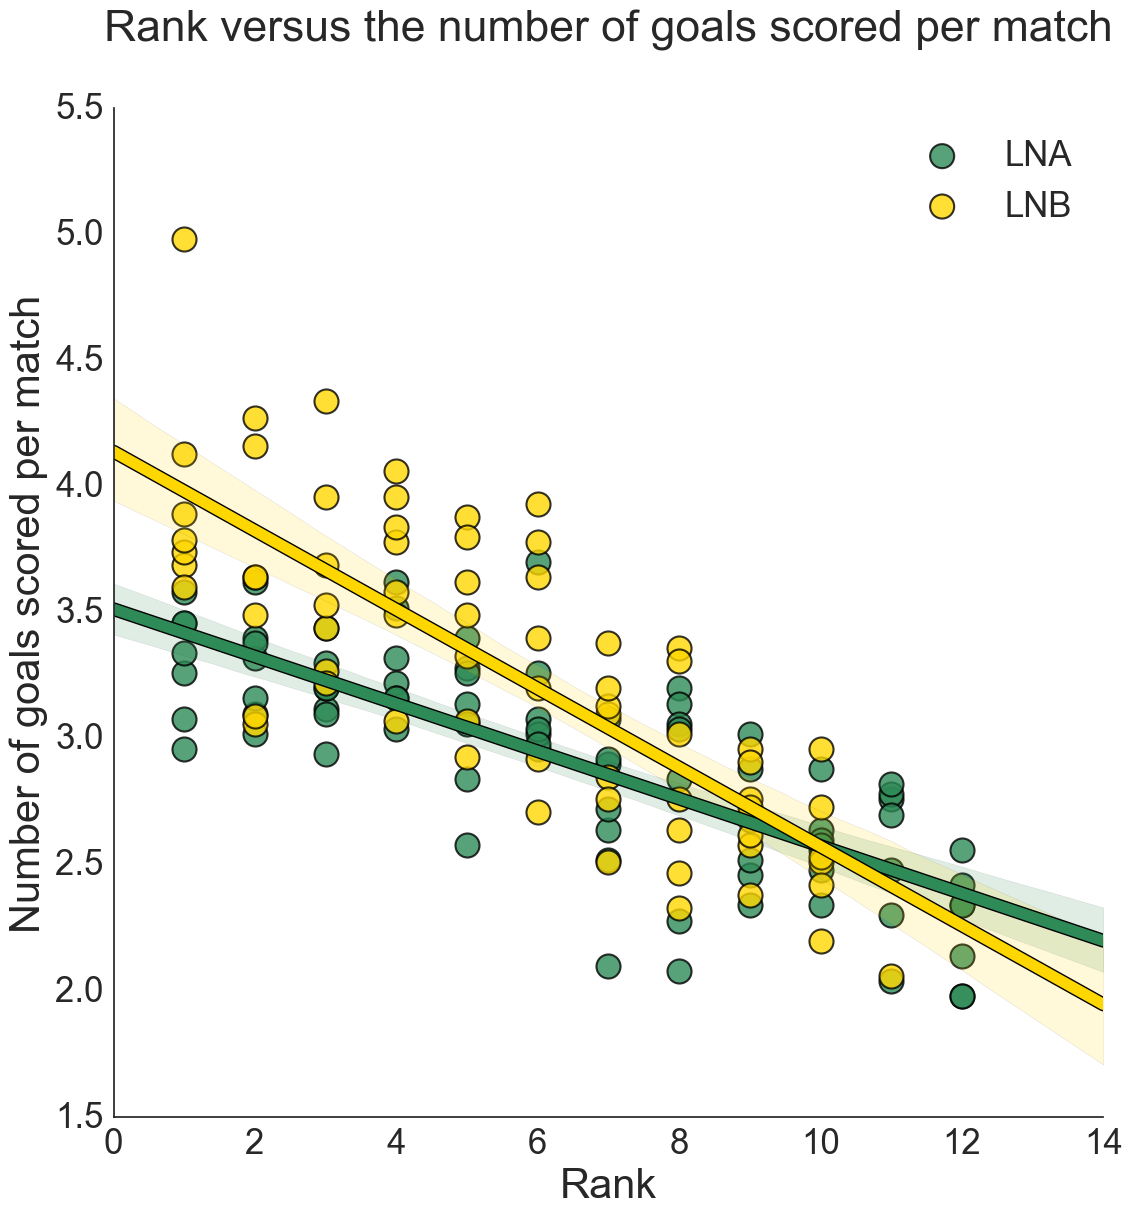

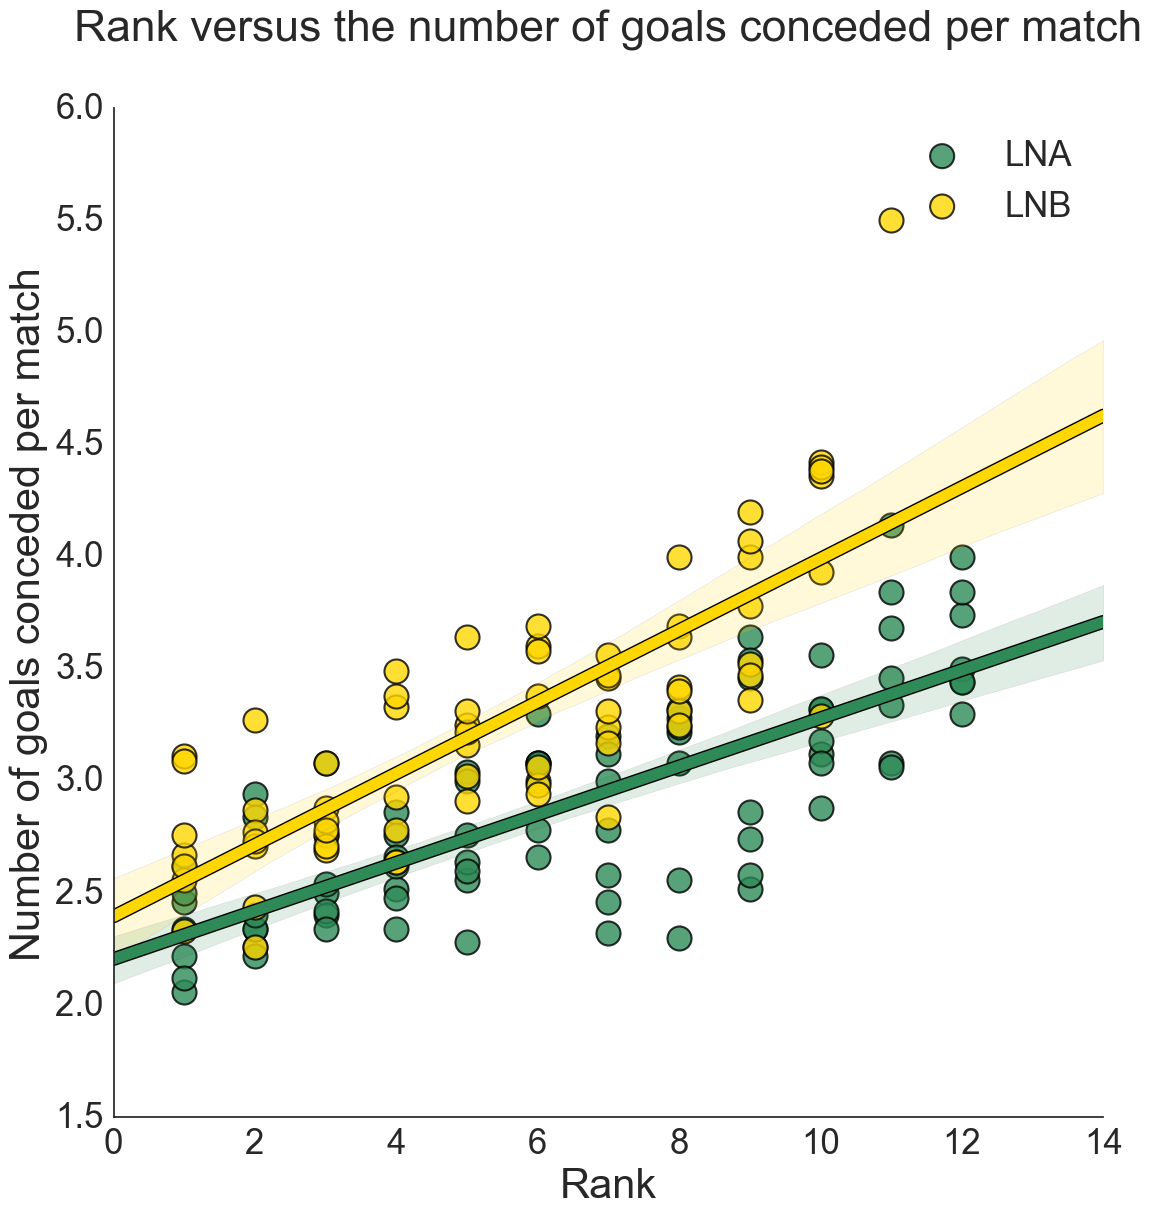

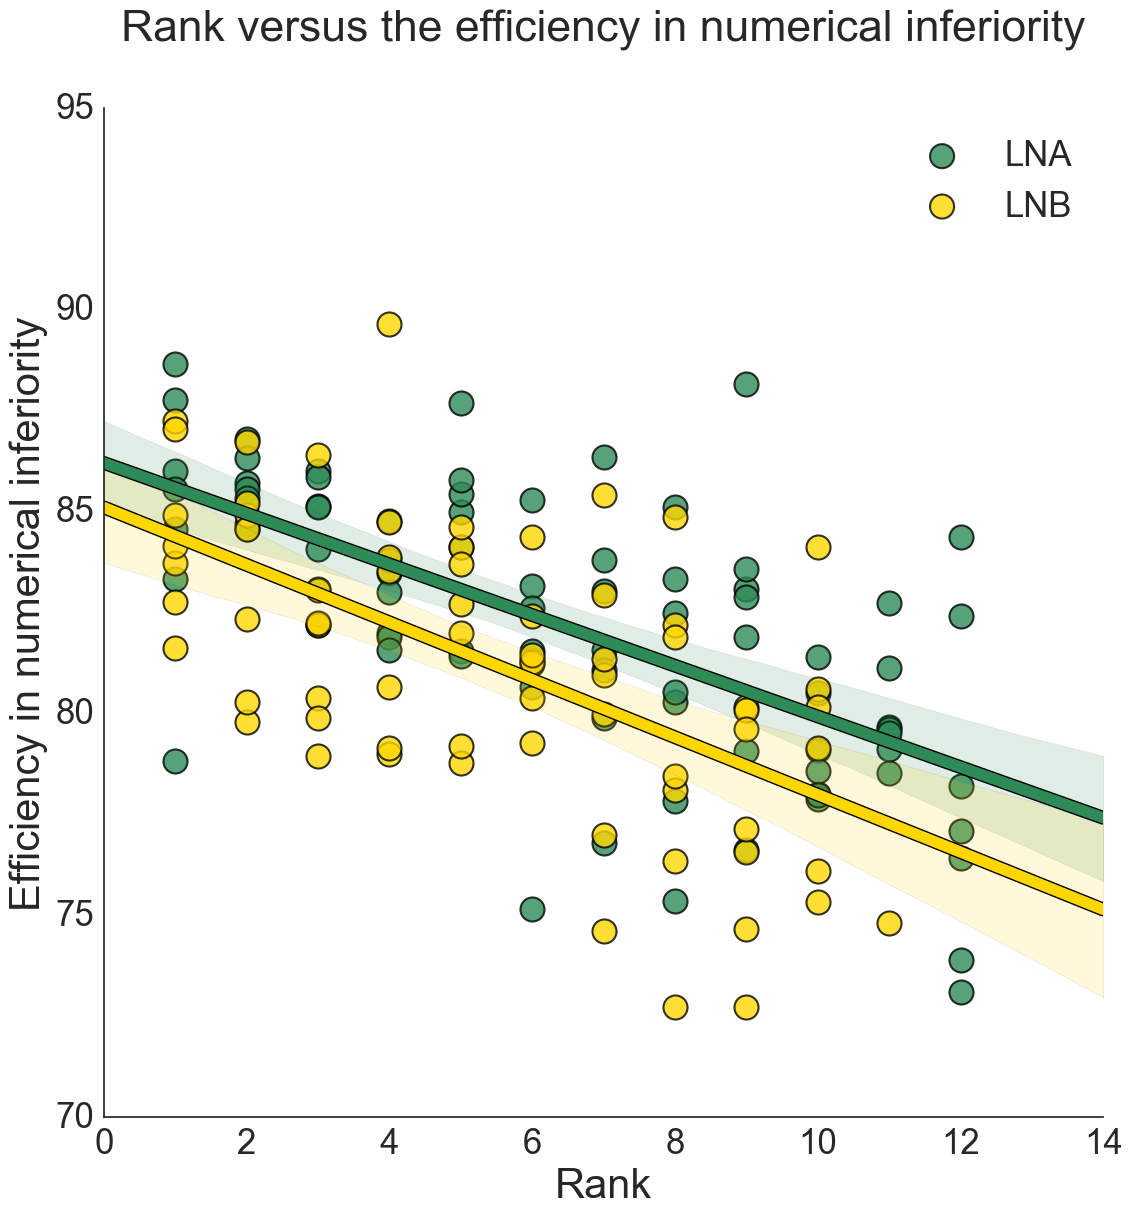

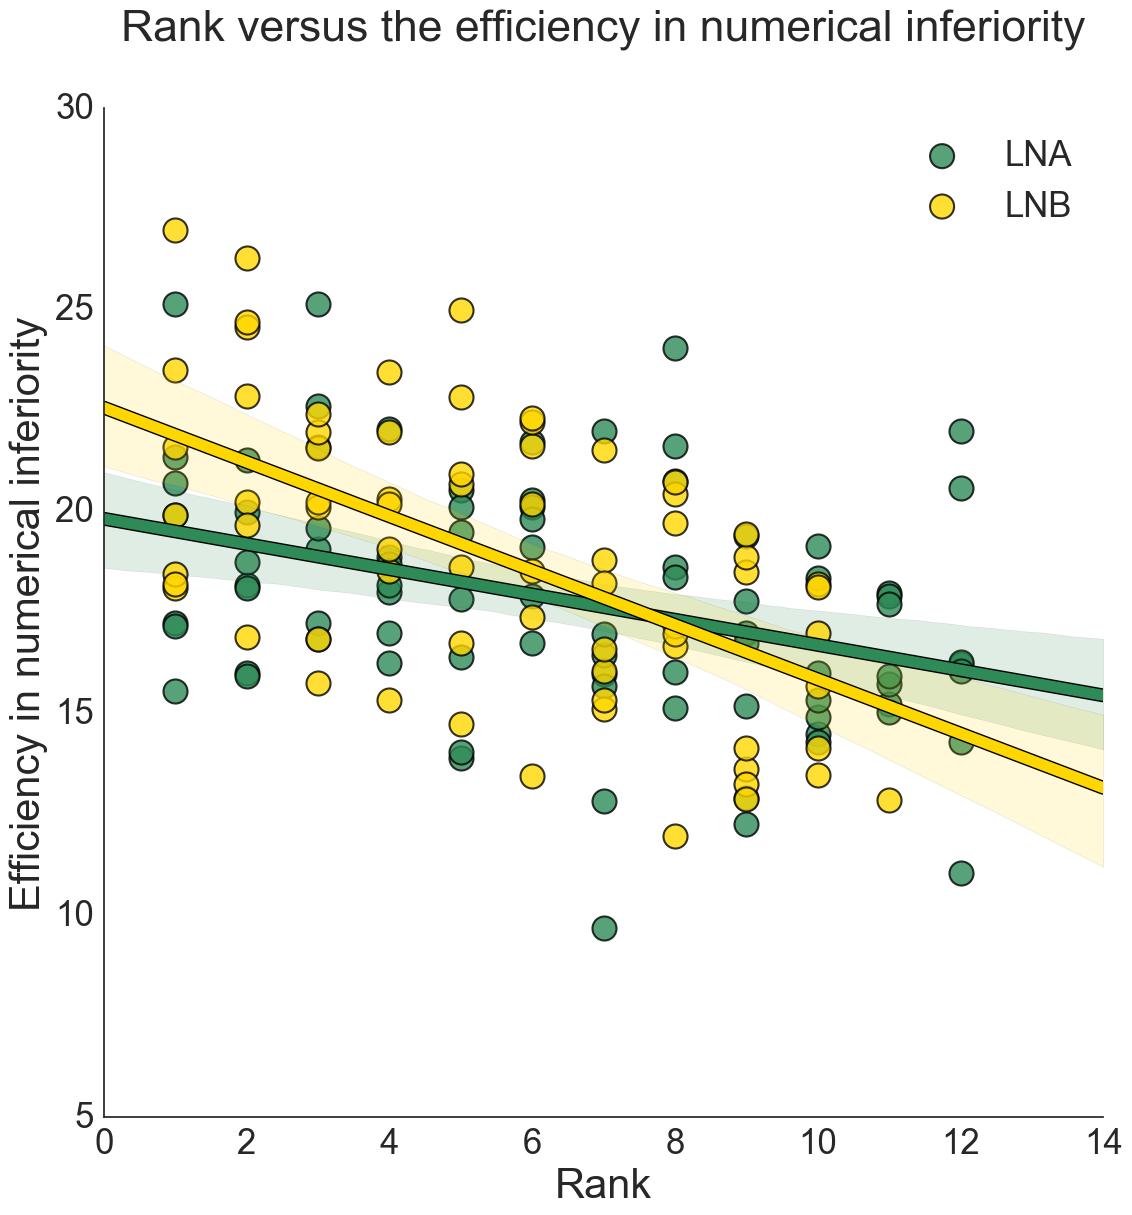

In [27]:
sns.set(style='white', color_codes=True,font_scale=2.5)

title_dict = {'GF/GP' : 'the number of goals scored per match',
             'GA/GP' : 'the number of goals conceded per match',
             'PK%' : 'the efficiency in numerical inferiority',
             'PP%' : 'the efficiency in numerical inferiority'}

axe_dict = {'GF/GP' : 'Number of goals scored per match',
             'GA/GP' : 'Number of goals conceded per match',
             'PK%' : 'Efficiency in numerical inferiority',
             'PP%' : 'Efficiency in numerical inferiority'}

for current in ['GF/GP', 'GA/GP', 'PK%' , 'PP%']:
    fig = plt.figure(figsize=(15,15))
    pal = dict(LNA="seagreen", LNB="gold")
    g = sns.lmplot(x='R', y=current, hue='League', data=df_feat_leagues, palette=pal, legend_out=False, size=12,
                   scatter_kws={"s": 300,'edgecolors': 'black', 'lw': 1.5 },
                   line_kws={'lw':8, 'path_effects':[pe.Stroke(linewidth=10, foreground='black'), pe.Normal()]})
    plt.xlabel('Rank', fontsize=30)
    plt.ylabel(axe_dict[current], fontsize=30)
    plt.title('Rank versus {}'.format(title_dict[current]), fontsize=32,  y=1.06)
    plt.legend(fontsize=25);

#    plt.savefig('Plots/features/____Ranking__vs__{}'.format(re.sub('[\s/]', '_', current)))